# Methods for Data Science: Coursework 2

## Neural networks

### MLP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import seaborn as sns;  sns.set_theme()
import pandas as pd
import scipy.linalg as linalg #eigenvalues
import networkx as nx

import itertools

import scipy.sparse.linalg #eigenvalues

import scipy.special #for binomial coefficient


In [4]:
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data() 
    x_train = x_train.astype('float32') /255 
    x_val = x_val.astype('float32') /255
    # convert labels to categorical samples 
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) 
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()


170500096/170498071 [==============================] - 2s 0us/step


Our first tasks will be to implement a multilayer perceptron using numpy. This MLP will have 5 hidden layers, each layer with 400 neurons and the output layer with 10.

The loss function used will be cross entropy. 

$cross\_entropy = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^k t_{i,j}log(p_{i,j})$

Where N is number of samples, k is number of classes (10), $t_{i,j}$ is 1 is if sample i is in class j, or 0 otherwise, p_{i,j} is the predicted probability that sample i is in class j. 

We write a function below that will calculate this loss function for a classification problem with 10 classes.

In [ ]:
def ce_loss(predictions,targets,epsilon=1e-12):
    #predictions one hot vector
    #targets one hot vector
    #epsilon to avoid log error
    predictions = np.clip(predictions, epsilon, 1. - epsilon) #remove boundary values
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-12))/N #add 1e-12 to avoid error with log(0)
    return ce


The function below will compute our gradients which we will combine with stochastic gradient descent.

In [ ]:

def grads(delta1, delta2, delta3, delta4, delta5, h0, h1):
    
    # delta1: K x 64 array of hidden layer errors
    # delta2: K x 1 array of output errors
    # h0: K x 6 array of inputs
    # h1: K x 64 array of hidden layer post-activations
    # returns: tuple of arrays of shape (6 x 64), (64,), (64 x 1), (1,) for gradients
    
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis]
    grad_b0 = delta1
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b1 = delta2
    grad_W2 = delta3[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b2 = delta3
    grad_W3 = delta4[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b3 = delta4
    grad_W4 = delta5[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b4 = delta5
    grad_W5 = delta6[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b5 = delta6    
    
    grad_W0 = tf.reduce_mean(grad_W0, axis=0)
    grad_b0 = tf.reduce_mean(grad_b0, axis=0)
    grad_W1 = tf.reduce_mean(grad_W1, axis=0)
    grad_b1 = tf.reduce_mean(grad_b1, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1


Below we have the dense function which takes the linear combination of neurons from each stage. We also have our tanh and softmax activation functions. These are used so that an output is only produced if there is sufficient magnitude.

In [ ]:
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W  ## <-- pre-activations
    return h

def tanh(h):
    #activation function
    h = np.tanh(h)
    return h

def softmax(h):
    e = np.exp(h)
    h = e/np.sum(e, axis=0)
    return h

Although we use stochastic gradient descent to update the weights, we need a way to initialise them. Here we use glorot intitialisation.

In [ ]:
#glorot initialisation
#3072 neurons in, 400 out
var0 = 2. / (400 + 3072)
W0 = np.random.randn(3072, 400) * np.sqrt(var0)
b0 = np.zeros(400)
#400 in 400 out
var1 = 2. / (400 + 400)
W1 = np.random.randn(400, 400) * np.sqrt(var1)
b1 = np.zeros(400)

var2 = 2. / (400 + 400)
W2 = np.random.randn(400, 400) * np.sqrt(var2)
b2 = np.zeros(400)

var3 = 2. / (400 + 400)
W3 = np.random.randn(400, 400) * np.sqrt(var3)
b3 = np.zeros(400)

var4 = 2. / (400 + 400)
W4 = np.random.randn(400, 400) * np.sqrt(var4)
b4 = np.zeros(400)
#400 in 10 out
var5 = 2. / (10 + 400)
W5 = np.random.randn(400, 10) * np.sqrt(var5)
b5 = np.zeros(10)


We need to calculate the derivative of our loss function with respect to the activation function so we can calculate output error. This is defined as below and a full derivation of this tidy result can be seen:http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/

The other derivative we need is the derivative of the activation function.

This derivative is used for the backpropagation.

In [ ]:
def output_error_ces(y_batch, yhat):#output error for cross entropy loss
    # y_batch: K x 1 array of data outputs
    # a5: K x 1 array of output pre-activations
    # returns: K x 1 array of output errors 
    return yhat - y_batch

def activation_derivative(a1):
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of diagonal elements  
    return 1 - np.square(np.tanh(a1))

def backpropagate(delta2, W1, a1):
    
    # delta2: K x 1 array of output errors
    # W1: 64 x 1 array
    # a1: K x 64 array of hidden layer pre-activations
    # returns: K x 64 array of hidden layer errors
    
    return np.squeeze(activation_derivative(a1)[..., np.newaxis] * W1 * delta2[:, np.newaxis, :])

Lastly, we put this together to train the MLP.

In [ ]:
learning_rate = 0.01
epochs=40

for epoch in range(epochs):
    for x_batch, y_batch in x_train:
        losses.append(tf.reduce_mean(tf.keras.losses.mse(y_batch, model(x_batch))).numpy())
        #forward pass
        a1 = dense(x, W0, b0)
        h1 = np.tanh(a1)
        a2 = dense(h1, W1, b1)
        h2 = np.tanh(a2)
        a3 = dense(h2, W2, b2)
        h3 = np.tanh(a3)
        a4 = dense(h3, W3, b3)
        h4 = np.tanh(a4)
        a5 = dense(h4, W4, b4)
        h5 = np.tanh(a5)
        a6 = dense(h5, W5, b5)
        y = softmax(a6)
        
        #backprop
        delta6 = output_error_ces(y_batch, y)
        delta5 = backpropagate(delta6, W5, a5)
        delta4 = backpropagate(delta5, W4, a4)
        delta3 = backpropagate(delta4, W3, a3)
        delta2 = backpropagate(delta3, W2, a2)
        delta1 = backpropagate(delta2, W1, a1)
        
        var_grads = grads(delta1, delta2, x_batch, h1)
        
        #sgd
        b0 -= learning_rate * var_grads[0]
        b1 -= learning_rate * var_grads[1]
        b2 -= learning_rate * var_grads[2]
        b3 -= learning_rate * var_grads[3]
        b4 -= learning_rate * var_grads[4]
        b5 -= learning_rate * var_grads[5]

This MLP does takes far too long run and is not very useful.

Although we were not able to analyse its performance, we can make some educated guesses about how changing learning rate and epochs would affect its results.

Smaller learning rates such as 0.0001 would mean that our MLP would be improving accuracy and decreasing loss too slowly. Within the 40 epochs, the total improvements would not be that substantial. As a result, the final model would not be very accurate or useful. The accuracy however, can be improved if more epochs are used.

On the contrary, learning rate set too high (0.1) could cause loss to diverge. The stochastic gradient descent would make jumps too big and potentially miss the the minima we are looking for. The accuracy for this model would be poor and using more epochs would not benefit this.

In general, using more epochs is useful provided that the loss has not converged yet and is still decreasing. However we also know that if we train for too long  we might find that the loss diverges and we would have wished we did not use so many epochs. In this case, we would have benefitted from early stoppage. 

### CNN

In the next section, we will use TensorFlow to implement a convolutional neural network. The architecture is as follows: four hidden layers (3 convolutional and 1 fully-connected layer), All convolutional layers apply 3x3 feature maps, the first uses 32 and the last two use 64 feature maps. Betweeen each convolutional layer is a 2x2 maximum pooling layer. The fully-connected layer has 64 neurons and is followed by a 10 neuron output layer. The ReLU activation function is used on all layers and the softmax activation function is used on the final layer. The optimisation method is stochastic gradient descent and the loss measured is cross entropy.

In [11]:
model2 = tf.keras.models.Sequential()
initializer = tf.keras.initializers.GlorotNormal()
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, input_shape=(32, 32, 3)))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model2.add(layers.Activation('softmax'))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model2.fit(x_train, y_train, batch_size=128, epochs=40, 
                    validation_data=(x_val, y_val), verbose=0)

We will now plot the loss and accuracy as a function of epoch.

Text(0.5, 1.0, 'Accuracy against Epoch for CNN')

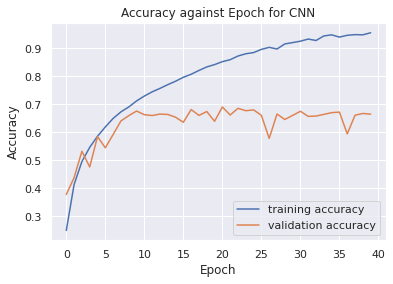

In [12]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Accuracy against Epoch for CNN')


Text(0.5, 1.0, 'Loss against Epoch for CNN')

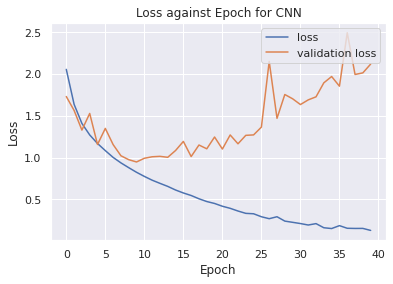

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.title('Loss against Epoch for CNN')

#test_loss, test_acc = model2.evaluate(x_val,  y_val, verbose=2)

The results of this CNN are as expected. As epoch increases, the training accuracy increases, reaching well over 90% accuracy by epoch 40. But for the validation set, the accuracy reaches the high 60s around epoch 10 and plateaus there whilst never exceeding 70%. The training loss is jsut about to converge by epoch 40, whereas the validation loss diverges from epoch 15.

This is a clear sign that our neural network is overfitting. To improve upon our model, we will use regularisation.

Our first regularisation method with be L2 regularisation. This puts a user defined penalty (we will use 5e-3) onto the coefficients. More specifically, the penalty value will scale $\beta_i^2$, the square of the weights that take linear combinations of our neurons. We will keep everything else in the neural network the same.

In [15]:
#L2 regularisation on convolutional layers
model3c = tf.keras.models.Sequential()

initializer = tf.keras.initializers.GlorotNormal()
model3c.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l2=5e-3), input_shape=(32, 32, 3), kernel_initializer=initializer))
model3c.add(tf.keras.layers.MaxPooling2D((2, 2)))
model3c.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l2=5e-3)))
model3c.add(tf.keras.layers.MaxPooling2D((2, 2)))
model3c.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l2=5e-3)))


model3c.add(tf.keras.layers.Flatten())
model3c.add(tf.keras.layers.Dense(64,activation='relu'))
model3c.add(tf.keras.layers.Dense(10, activation='softmax'))


model3c.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


history3c = model3c.fit(x_train, y_train, batch_size=128, epochs=40, 
                    validation_data=(x_val, y_val),verbose=0 )

Once again, we splot the same loss and accuracy graphs against epoch.

Text(0.5, 1.0, 'Accuracy against epoch for CNN with L2 reg (L=5e-3)')

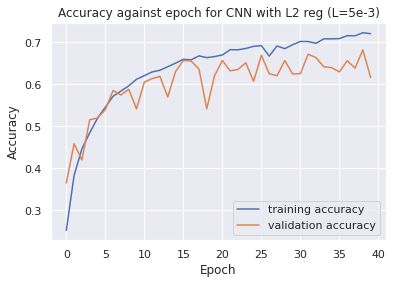

In [16]:
#Plots of accuracy with L2 regularisation
plt.plot(history3c.history['accuracy'], label='training accuracy')
plt.plot(history3c.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Accuracy against epoch for CNN with L2 reg (L=5e-3)')

Text(0.5, 1.0, 'Loss against epoch for CNN with L2 reg (L=5e-3)')

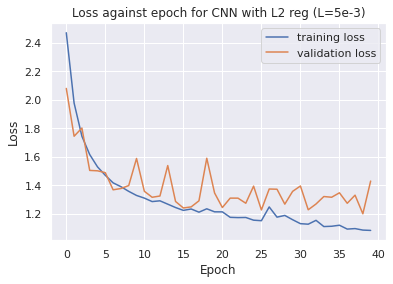

In [17]:
#Plots of losses with L2 reg
plt.plot(history3c.history['loss'], label='training loss')
plt.plot(history3c.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.title('Loss against epoch for CNN with L2 reg (L=5e-3)')

For this neural network, we can see slight benefits to using the regularisation; the model is not overfitting now. By the 40th epoch, training accuracy is just over 70%, but the validation accuracy is seems to fluctuate around 65% again. The validation loss does not diverge anymore either and has a decreasing trend just like the training loss. 

Whilst, there will be improvements to be found by using more epochs (so we can see the loss and accuracy converge and not fluctuate) and a slower learning rate (so we avoid the risk of getting stuck in a local minima), we can probably conclude that our model is now underfitting. This means our regularisation technique is a bit too strong. If we wanted to use L2-regularisation, perhaps we should look towards using smaller values next time.

The next regularisation method we will use is dropout. This methods involves us dropping out a random proportion of the neurons at certain layers. This adds some variability and works similarly to a random forrest when we choose a random subset of features to split on. The dropout hyperparameter in TensorFlow represents the proportion of neurons that we will drop. 

We have chosen to drop 0.5 of all neurons after the final convolution and before the penultimate fully connected layer. It is important that we do not drop out neurons just before the final layer since the model will not be able to recover information if there are no more layers to be calculated. In addition to this, we do not want to discard neurons at the end of our model since these are also the ones which are closest to the output.

In [18]:
#dropout regularisation
#https://arxiv.org/pdf/1207.0580.pdf
#http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf
#https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
model4 = tf.keras.models.Sequential()

initializer = tf.keras.initializers.GlorotNormal()
model4.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(32, 32, 3), kernel_initializer=initializer))
#model4.add(tf.keras.layers.Dropout(0.1))
model4.add(tf.keras.layers.MaxPooling2D((2, 2)))

model4.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model4.add(tf.keras.layers.Dropout(0.1))

model4.add(tf.keras.layers.MaxPooling2D((2, 2)))
model4.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model4.add(tf.keras.layers.Dropout(0.1))



model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dropout(0.5))

model4.add(tf.keras.layers.Dense(64,activation='relu'))
model4.add(tf.keras.layers.Dense(10, activation='softmax'))


model4.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


history4 = model4.fit(x_train, y_train, batch_size=128, epochs=40, 
                    validation_data=(x_val, y_val),verbose=0)

Text(0.5, 1.0, 'Accuracy against epoch for CNN with dropout reg (0.5)')

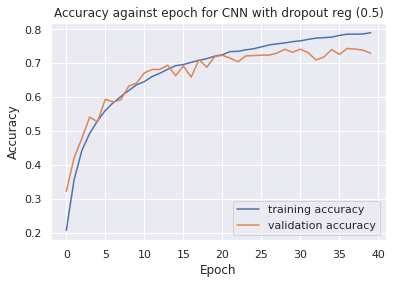

In [19]:
#Plots of accuracy with dropout regularisation
plt.plot(history4.history['accuracy'], label='training accuracy')
plt.plot(history4.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Accuracy against epoch for CNN with dropout reg (0.5)')

Text(0.5, 1.0, 'Loss against epoch for CNN with dropout reg (0.5)')

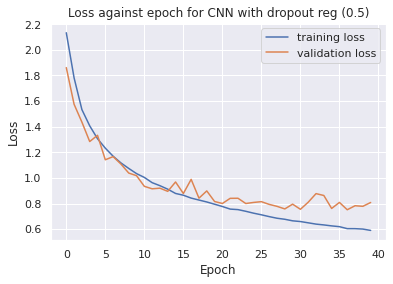

In [20]:
#Plots of losses with dropout reg
plt.plot(history4.history['loss'], label='training loss')
plt.plot(history4.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.title('Loss against epoch for CNN with dropout reg (0.5)')

Using dropout, we have achieved our highest validation accuracy (~75%) at epoch 40. This also corresponds to a training accuracy of ~80%, thus our model does not appear to be overfitting. The loss against epoch graph also looks more promsising than those of the past two models; it fluctuates less and has not diverged. 

Given more epochs and/or a smaller learning rate, I believe that this model can perform even better as the training loss appears to be still decreasing at epoch 40.

Regardless, this 75% accuracy is significantly higher than the previous models and we can be very certain that this is not by chance since the chance of randomly guessing 7500/10000 on a 10-class problem is very small ~6e-5175. 

We will try and use one more regularisation method in this section. 

From https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf, the author reports that there is a significant reduction in classification error when using L2 regularisation in combination with dropout. We will attempt to recreate these results. The paper http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf also mentions that there is some benefit in adding dropout layers with small hyperparameter value (0.1=0.2) after all convolutions.

The model below has two dropout layers with rate 0.05 and one with 0.4. It also uses L2 regularisation with $\lambda = 5\cdot 10^{-4}$. These were the best parameters out of a few different permutations that were tried. The reasoning behind these values are that there are smaller than than the hyperparameter values that we tried when we used each technique individually earlier. When both regularisation techniques were used independently, we did not notice any overfitting and so using both techniques with the same values as previous would cause too much underfitting.


In [21]:
#reg
#https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
model5 = tf.keras.models.Sequential()

initializer = tf.keras.initializers.GlorotNormal()
model5.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(32, 32, 3), kernel_regularizer = tf.keras.regularizers.l2(l2=5e-4), kernel_initializer=initializer))
model5.add(tf.keras.layers.Dropout(0.05))
model5.add(tf.keras.layers.MaxPooling2D((2, 2)))

model5.add(tf.keras.layers.Conv2D(64, (3, 3),kernel_regularizer = tf.keras.regularizers.l2(l2=5e-4), activation='relu'))
model5.add(tf.keras.layers.Dropout(0.05))


model5.add(tf.keras.layers.MaxPooling2D((2, 2)))
model5.add(tf.keras.layers.Conv2D(64, (3, 3),kernel_regularizer = tf.keras.regularizers.l2(l2=5e-4), activation='relu'))




model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dropout(0.4))

model5.add(tf.keras.layers.Dense(64,activation='relu'))

model5.add(tf.keras.layers.Dense(10, activation='softmax'))


model5.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


history5 = model5.fit(x_train, y_train, batch_size=128, epochs=40, 
                    validation_data=(x_val, y_val),verbose=0)

The usual plots are made.

Text(0.5, 1.0, 'Accuracy against epoch for CNN with dropout and L2 reg')

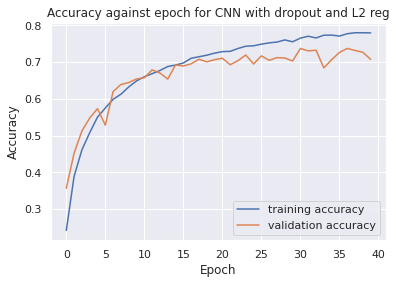

In [22]:
#Plots of accuracy with l2 + dropout regularisation
plt.plot(history5.history['accuracy'], label='training accuracy')
plt.plot(history5.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Accuracy against epoch for CNN with dropout and L2 reg')

Text(0.5, 1.0, 'Loss against epoch for CNN with dropout and L2 reg')

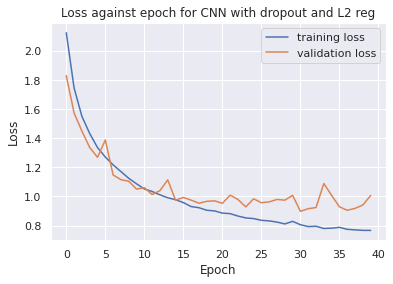

In [23]:
#Plots of losses with l2 + dropout reg
plt.plot(history5.history['loss'], label='training loss')
plt.plot(history5.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.title('Loss against epoch for CNN with dropout and L2 reg')

Whilst we can note that the dropout+L2 is slightly better than just using L2 (L2+ dropout has some epochs with over 70% accuracy, whereas L2 does not have any), this method was not better than just using dropout on its own.

Perhaps this could simply be because we have not spent the time grid searching to find the optimum hyperparameters. Another explanation could be that the nature of neural networks produces results that are very specific to the data they are trained on. The paper we reference was using MNIST data (handwritten digits) and our data contains images of real life objects. The features required to identify objects vs digits are almost certainly very different. Our data is also RGB whereas MNIST is black and white.

Comparing the performance of the CNN to the MLP - the CNN was significantly more accurate. We should not be surprised by this since the convolution layers can effectively identify local features since they take into account the information that is in the neighbourhood of any pixel. The MLP does not do this, it will take linear combinations of any pixels across the image and assumes that pixels from different parts of the image and in different RGB channels are as related as pixels next to each other. When it comes to images where lots of information is in local neighbourhoods and small features, the CNN will perform significantly better than the MLP. 

The last thing we can look at is the timings of all the neural networks. The CNNs we used were all trained using GPUs since these were implemented in TensorFlow and can be GPU accelerated on google colab. CNN in 1.2.3 took 3s per epoch and 8ms per step. This was slower than the the CNNs in 1.2.1 and 1.2.2 which took 2s per epoch and 6ms per step. This difference is due to the extra computations to do two regularisation techniques. 

Using a CPU with the CNN in 1.2.3, we have a time of 60s per epoch and 150ms per step. This is quicker than our MLP which took minutes per epoch when using the CPU. In general CNNs are faster to fit than MLPs. This is because the weights are smaller and shared in the CNN, whereas the MLP has a weight for each pixel value. The CNN also treats the image like a matrix, whereas the MLP unpacks the image into a long vector which is slower to process. Lastly, the MLP is fully connected on each layer, whereas the CNN is sparsely connected on the convolution layers; only the local patch of pixels are connected.



So we conclude that using a CNN is is much better than a MLP for image classification. This is likely because the convolution layers are very effective in identifying local features. The MLP does not have a sense of which pixel values are in the neighbourhood of each other and will not be able to do the same. The CNN is also much faster than the MLP because it has smaller and less weights to compute and less connections to account for.

For image classification of CIFAR data with a CNN, using dropout layers was the best regularisation method we discovered. 

For curiousity, we will explore what happens when our model is used on data that is not from this dataset. A 32x32 pixel image has been loaded and we use our model4 to see what this image is predicted as.

(32, 32, 3)


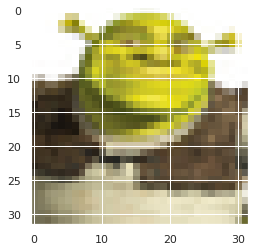

In [128]:
import imageio
im = imageio.imread('shrek(1).png')
shrek = im/255
shrek2 =  np.expand_dims(shrek, axis=0)
plt.imshow(shrek)
cifarlab = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

<function matplotlib.pyplot.show>

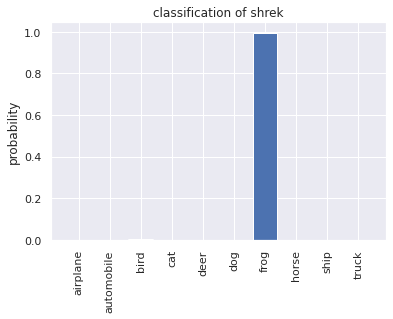

In [146]:
pred=model4.predict(shrek2)[0]
plt.bar(x= np.arange(10),height=pred/np.sum(pred))
plt.xticks(np.arange(10),cifarlab,rotation='vertical')
plt.title('classification of shrek')
plt.ylabel('probability')
plt.show


The model is almost certainly convinced that our image of shrek is actually an image of a frog. This demonstrates the limitations of neural networks; they are very effective until they are given data that deviates from the training set. In this example, shrek has been classified as a frog likely because he is green. So whilst it is impressive that our model had a 75% accuracy, some of the features it looks for might be quite rudimentary, such as green objects are classified as frogs with no uncertainty.

In [25]:
from google.colab import files
uploaded = files.upload()

Saving feature_matrix_karate_club.csv to feature_matrix_karate_club.csv
Saving karate_club_graph.csv to karate_club_graph.csv
Saving ground_truth_karate_club.csv to ground_truth_karate_club.csv


## Unsupervised learning

In this next section we will explore some unsupervised learning methods. Working with the karate club graph, we will try to find an optimal clustering for this dataset.

In [27]:
#load dataset
f_mat = np.genfromtxt ('feature_matrix_karate_club.csv', delimiter=",")[1:,1:] #drop column and row headers
n_samples,n_features = f_mat.shape #34 rows for items, 100 columns for features

### K-means clustering

The function below will use K-means to cluster a given adjacency matrix. This algorithm assigns random clusters to all the data points and then computes the distances between each datapoint and the different centroids. Then the datapoints are assigned new labels for the centroids that are closest to these points. This iterates until the labels for the data points do not change, or alternatively when 100 iterations (variable can be changed) has finished.

The Calinsky-Harabasz index is a metric that measures clustering performances. This metric is computed by taking the ratio of between cluster dispersion and within cluster dispersion. More specifically, the formula is 

$CH = \frac{\sum_{q=1}^{k}\sum_{x \in C_q}||x - c_q||^2}{\sum_{q=1}^{k}n_q||c_q-c_F||^2} \cdot \frac{n_F-k}{k-1}$

Where $C_q$ is a set of points in cluster q, $c_q$ is the centroid of cluster q, $c_F$ is the center of the dataset F, $n_q$ is the number of points in cluster q and $n_F$ is the number of points in the dataset F.

In [28]:
#km cluster function that outputs CH index
def km_cluster(f_mat,k,seed=2,max_iter=100):
    """
    Parameters
    ----------
    f_mat : feature matrix, rows are datapoints, columns are features
    k : number of clusters
    seed: for repeatable results
    max_iter : maximum iterations to recalculate dsitances for
    Returns
    -------
    new_labels: vector of labels with length matrix.shape[0]
    centroids: matrix with k rows, each representing a centroid
    ch: calinsky harabasz index
    wk: within cluster distance
    """
    n_samples, n_features = f_mat.shape #34 rows for items, 100 columns for features
    
    np.random.seed(seed) #set seed
    labels = np.random.randint(low=0, high=k, size=n_samples) #assign random cluster
    F_labels = np.append(f_mat, labels.reshape(-1,1), axis=1) #add labels to f matrix
    
    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        
        if sum(labels==i)==0: #if we have no labels of value i
            continue
        
        centroids[i] = np.mean([x for x in F_labels if x[-1]==i], axis=0)[0:100] #mean of each feature
    
    
    for i in range(max_iter):
        #print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(f_mat - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
    
        if (labels==new_labels).all():#stop criterion
            # labels unchanged
            labels = new_labels
            #print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)    
            #print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                  centroids[c] = np.mean(f_mat[labels==c], axis=0)            
    wk = 0. #initialise
    bk = 0.  
    ce = np.mean(f_mat, axis=0) #center of data
    
    for xi in range(len(new_labels)): #for each data point
        xlcq = f_mat[xi,:] - centroids[new_labels[xi]] #x less centroid q 
        wk = wk + np.dot(xlcq,xlcq) #sum of squares
        
        cqlce = centroids[new_labels[xi]] - ce
        bk = bk + sum(new_labels==new_labels[xi])*np.dot(cqlce,cqlce)/k
        
    ch = (bk/wk) * (n_samples - k/k-1) #ch index

    return new_labels, centroids, ch, wk


The next function will take our above function and cluster a number of different k values (cluster size) and at a number of different initialisations. The within cluster distances and CH score are averaged across all the clusterings for a given k value.

In [29]:
def km_clus_opt(kstart, kstop, seeds, f_mat):
    """
    kstart,kstop: range of k integer values
    seeds: number of clusters to do per k value
    f_mat: adjacency matrix
    """
    with_clus= np.zeros((kstop-kstart,seeds)) #preallocate space
    cal_har = np.zeros((kstop-kstart,seeds))
    for k in range(kstart,kstop): #for each k value
        for ri in range(seeds): #for each run
            results = km_cluster(f_mat, k, seed=ri) #cluster
            with_clus[k-kstart,ri] = results[3] #store results
            cal_har[k-kstart,ri] = results[2]
    return with_clus, cal_har

We will vary k from 2 to 10 and have 100 clusters per k value.

In [30]:
results = km_clus_opt(2,11,100,f_mat)


The plot below show the within cluster distance against k value. For this kind of graph, we look for an elbow to decide the optimum k value. It is hard to identify for this graph, but we decide that the optimum k value according to within cluster distance is 4. The within cluster decreases as k increases since addings clusters means there are more centroids and so more centroids per datapoint, thus each datapoint has more weight towards each cluster and this sum of squares decreases.

Text(0, 0.5, 'within cluster distance (euclidean)')

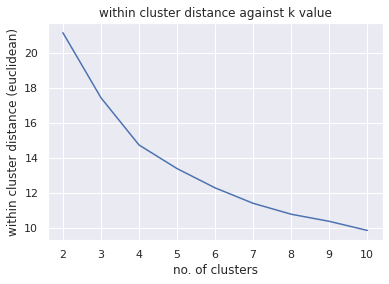

In [31]:
plt.plot(np.arange(2,11),np.mean(results[0],axis=1)) #elbow at 2/3
plt.title('within cluster distance against k value')
plt.xlabel('no. of clusters')
plt.ylabel('within cluster distance (euclidean)')


Text(0.5, 1.0, 'Calinski-Harabasz score against K value')

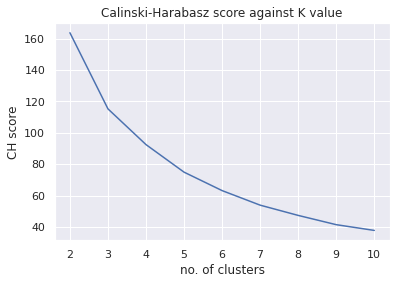

In [32]:
#ch score
plt.plot(np.arange(2,11), np.mean(results[1],axis=1)) #4

plt.ylabel('CH score')
plt.xlabel('no. of clusters')
plt.title('Calinski-Harabasz score against K value')


Using Calinski-Harabasz score, we can also hypothesise what the optimum number of clusters is. This score measures the ratio of between cluster sum of squares against the within cluster sum of squares. A higher score is better since this means the clusters are far from each other and the points within each cluster lie close to the cluster.

The highest score is at k=2. From our last graph, we saw that the within cluster distances is decreasing as k increases. The fact that the CH score is also decreasing as k increases suggests that the between cluster sum of squares is not decreasing as rapidly as the within cluster sum of squares.

Now we will discus the consistency and variability of the different clusters.

First we will look at the consistency of the results. We will plot a boxplot of within cluster dispersion for each k value.

<function matplotlib.pyplot.show>

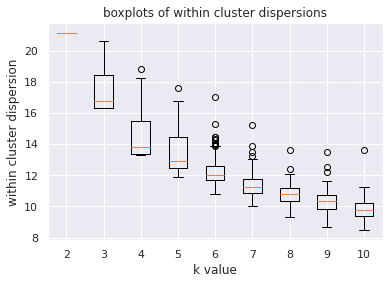

In [33]:
with_clus = results[0] #within cluster sum of squares for each k value each iteration

plt.figure
plt.boxplot(with_clus.T)
plt.xticks(ticks=np.arange(1,10),labels=np.arange(2,11))
plt.xlabel('k value')
plt.ylabel('within cluster dispersion')
plt.title('boxplots of within cluster dispersions')
plt.show

Most notable is the fact that k=2 has no variation. For every random initialisation, we achieved the same within cluster dispersion, which suggests that there is only one way to cluster the karate club into 2 groups. So 2-mean clustering is very repeatable and consistent. For the other k values, the clusters we found were often very different and there are various clusters that had a dispersion outside the interquartile range (especially k=6). These can be identified with the circles. At large k, the interquartile range, and variance of the dispersion seems to decrease. This is probably because the increased number of clusters/centroids means that the data points each have more personalised centroids and does not guarantee that the results from the different clusterings are similar. So k-mean clustering for k>2 is not that consistent.

<function matplotlib.pyplot.show>

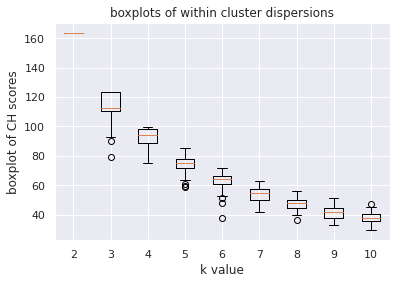

In [34]:
ch = results[1] #within cluster sum of squares for each k value each iteration


plt.figure
plt.boxplot(ch.T)
plt.xticks(ticks=np.arange(1,10),labels=np.arange(2,11))
plt.xlabel('k value')
plt.ylabel('boxplot of CH scores')
plt.title('boxplots of within cluster dispersions')
plt.show

For the variability of the results, we look back to the Calinski-Harabasz score. This is a ratio of between and within cluster sum of squares. To reiterate, we achieved our highest score with k=2 and this means that there is a good balance between compactness of each cluster, and distance between different clusters. This means that there is not as much ambiguity about which cluster a datapoint lies in. 

For larger k values, we have smaller CH scores. We also know that larger K value has lower within cluster distance, so this poor CH score means that the between cluster distances are very small. This is bad because there is now some uncertainty with datapoints that lie between two clusters. If there is a measurement error, then a datapoint might end up being wrongly clustered into a group that lies close to its true group. So for k>2 the variability of our results is large.

To conclude, k=2 appears to be the optimum cluster size according to the analysis we have done above. This is because it has a good CH score and is very consistent. This is reasonable since the karate club partitions into two groups.

### PCA

In the next section we will use principal components analysis to reduce the dimension of our data before clustering it. 

The first stage is to standardise the feature matrix. This is important because PCA looks for maximum variance, but the variance comparisons would not be meaniningful if the variables had different scales.

In [35]:
#standardise feature matrix
f_mat_std = np.zeros_like(f_mat)

for ci in range(f_mat.shape[1]):#for each column
    mean = np.mean(f_mat[:,ci])
    sd = np.std(f_mat[:,ci])
    f_mat_std[:,ci] = (f_mat[:,ci] - mean)/sd #subtract mean and scale with sd

The next step is to calculate the covariance matrix by multiplying the standardised matrix by its tranpose. Then the matrix is decomposed with the spectral value decomposition to return its eigenvectors and eigenvalues. We can then use k largest eigenvectors to project the original data onto a reduced dimension k space.

Text(0.5, 0, 'Eigenvalue')

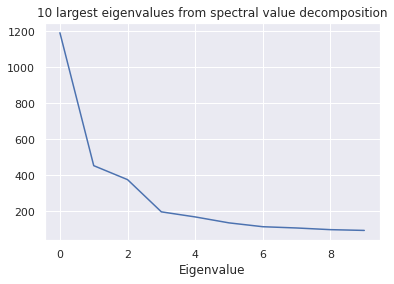

In [36]:
def PCA(f_mat, k):

    cov_mat = np.dot(f_mat_std.T, f_mat_std) #covariance matrix
    e_val, e_vec = scipy.sparse.linalg.eigsh(cov_mat, k, which="LM", return_eigenvectors=True) 
    
    sorted_index = np.argsort(e_val)[::-1] #reverse order for sorting because of eigsh function
    e_val=e_val[sorted_index] #sort
    e_vec=e_vec[:,sorted_index]

    # transform our data
    PCA = f_mat_std.dot(e_vec) #projection
    
    return PCA, e_vec, e_val
#run PCA for different values
PCA3 = PCA(f_mat_std,3)
PCA2 = PCA(f_mat_std,2)
PCA1 = PCA(f_mat_std,1)
PCA10 = PCA(f_mat_std,10)

plt.title('10 largest eigenvalues from spectral value decomposition')
plt.plot(PCA10[2])
plt.xlabel('Eigenvalue')


The plot above shows the 10 largest eigenvalues. These eigenvalues correspond to the eigenvectors that we will use for our projection into lower dimensional space. We can look for an elbow in this graph to decide the optimal number of principal components to use. From this graph it looks like 2 or 3 will be the best choice.

We will plot some scattergraphs of the dimension reduced dataset and compare with our k means cluster results.

In [37]:
#colour labels

lab2 = km_cluster(f_mat,2)[0] #get cluster labels
lab3 = km_cluster(f_mat,3)[0]

col2 = [] #empty lists 
col3 = []

#create colour list for plotting
for i in range(34):
    if lab2[i] ==0:
        col2.append('red')
    else:
        col2.append('blue')
        
for i in range(34):
    if lab3[i] ==0:
        col3.append('magenta')
    elif lab3[i]==1:
        col3.append('red')
    else:
        col3.append('yellow')
        
        

Text(0.5, 1.0, '1D PCA projection coloured with previous K-means clustering (k=2)')

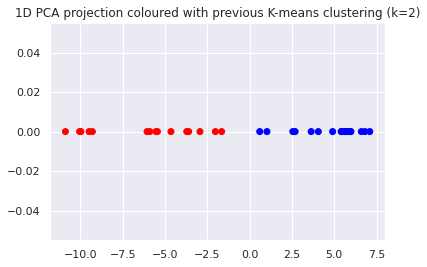

In [38]:
plt.scatter(PCA1[0],np.zeros(34), c=col2)
plt.title('1D PCA projection coloured with previous K-means clustering (k=2)')

Text(0.5, 1.0, '2D PCA projection, 2-means clustering colouring ')

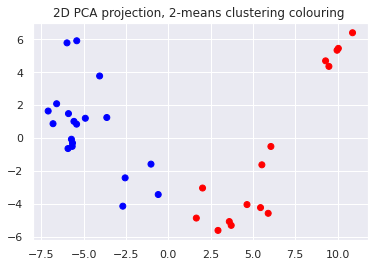

In [39]:
plt.scatter(PCA2[0][:,0],PCA2[0][:,1],c=col2)
plt.title('2D PCA projection, 2-means clustering colouring ')

Text(0.5, 0.92, '3D PCA projection and 3-mean clustering colouring')

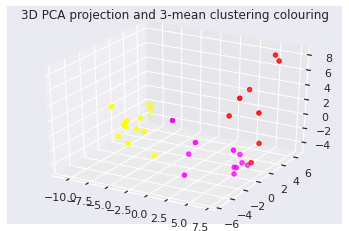

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(PCA3[0][:,0],PCA3[0][:,1],PCA3[0][:,2], c=col3)
ax.set_title('3D PCA projection and 3-mean clustering colouring')

The PCA scatter plots have a lot of similarity to the k-means clusterings. The clusterings from higher dimensional space also appear to be accurate clusterings for the projected lower dimension space

Furthermore the PCA projected subspace is almost identical to the k-means cluster centroids subspace.

An explanation for this could be that PCA reduces the dimension by representing the original datapoints in a new space that is spanned by a linear combination of eigenvectors, and this minimises a mean squared error. K-means represents the data points as linear combinations of centroid vectors and minimises anoter mean squared error (euclidean distance in this case). http://ranger.uta.edu/%7Echqding/papers/KmeansPCA1.pdf

This being said, this result does not hold true for every data set; there exist counterexamples to this relationship. https://arxiv.org/abs/1410.6801


The y axis scale was a bit hard to read on our last eigenvalue plot so we will rescale this and plot the explained variance. This is calculated by dividing the eigenvalues with the overall variance, which we calculate by taking the trace of the covariance matrix. The graph will look the same but now we have some meaning to the y axis. This represents the proportion of variance that is explained by this principal component.

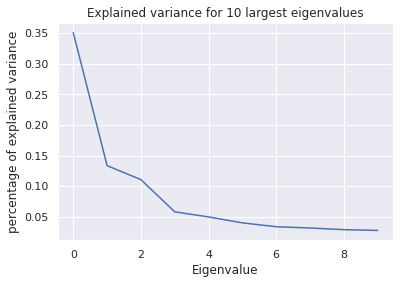

In [42]:
top10eval = PCA10[2]
cov_mat = np.dot(f_mat_std.T, f_mat_std) #covariance matrix

ov_var = np.trace(cov_mat) #sum of diagonal entries is overall variance

var_expl = top10eval/ov_var #explained variance

plt.title('Explained variance for 10 largest eigenvalues')
plt.xlabel('Eigenvalue')
plt.ylabel('percentage of explained variance')
plt.plot(var_expl)


To conclude, PCA can be very useful in that it can reduce dimensions. In the cases where we can reduce to 3 dimensions, then we are able to visualise our data and perform k-means clustering if we want. Reducing the dimension to a point where we capture a large amount of explained variance with a few principal components also means that our calculations are far less expensive to compute.

The PCA projections are also strongly linked to k-means clustering. Our projections shows the results of the k means clusterings, which appear to be good in the 1 and 2 dimension space, but not that good in the 3d space. Later in this project we will measure the kmeans clustering performance against the ground truth using a different metric that does not use euclidean distances.

### Centrality

In the next section we will measure three different centralities of the this graph using the adjacency matrix. The centrality gives us some idea of how important a node is. We note that this graph is undirected and this can be checked by testing the adjacency matrix for symmetry.

In [44]:
#load adjacency matrix
a_mat = np.genfromtxt ('karate_club_graph.csv', delimiter=",")[1:,1:]

np.allclose(a_mat,a_mat.T) #check symmetric e.g. undirected

True

The first centrality measure is degree centrality. This counts the number of nodes connected to each node. It has been scaled so that the centralities sum to 1 and we will be able to compare the results of all the centralities we calculate.

In [45]:
def deg_cen(a_mat):
    degree = np.sum(a_mat,axis=0) #sum count of node connections, axis doesnt matter since symmetric matrix
    return degree/ np.sum(degree)#scale to sum to 1 so that it can be compared

degr = deg_cen(a_mat)
print('Degree centrality:',degr)

Degree centrality: [0.1025641  0.05769231 0.06410256 0.03846154 0.01923077 0.02564103
 0.02564103 0.02564103 0.03205128 0.01282051 0.01923077 0.00641026
 0.01282051 0.03205128 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01923077 0.01282051 0.01282051 0.01282051 0.03205128
 0.01923077 0.01923077 0.01282051 0.02564103 0.01923077 0.02564103
 0.02564103 0.03846154 0.07692308 0.10897436]


This next metric is eigenvector centrality. We use SciPy's eig function to get the eigenvalues and eigenvectors, which have been sorted by magnitude of eigenvalue. The vector corresponding to the largest eigenvalue is then scaled to produce the output. The Perron Frobenius theorem guarantees that the vector our function extracts will be the the correct one.

In [46]:
def evec_cen(a_mat):
    
    es = linalg.eig(a_mat) #evals and evecs sorted
    largest_evec = es[1][:,0]
    
    if np.sign(es[1][0,0]) <0: #assuming all components have same direction since we took largest val
        largest_evec = -largest_evec
    
    if np.sum(np.sign(largest_evec))!= len(a_mat): #checking if all evec components had same sign
        print('sign warning') #should not flag because perron frobenius
    
    return largest_evec/np.sum(largest_evec) #evec for largest eval
    
evec = np.abs(evec_cen(a_mat))
print('Eigenvector centrality:',evec)

Eigenvector centrality: [0.07141273 0.05342723 0.06371906 0.04242274 0.01526096 0.01596691
 0.01596691 0.03434317 0.04568193 0.02062567 0.01526096 0.01061789
 0.01692545 0.04549486 0.02037035 0.02037035 0.00474803 0.01856164
 0.02037035 0.02971333 0.02037035 0.01856164 0.02037035 0.0301565
 0.01146095 0.01189366 0.01518273 0.02681349 0.02633151 0.02711154
 0.03510624 0.03837574 0.06200185 0.07500294]


The last centrality is pagerank. This is calculated by scaling the columns of the adjacency matrix by the degree of respective nodes. Then we iterate and multiply this last matrix (google matrix) by a vector that we initialise as a vector of 1s. The output is then used to multiply the google matrix and this repeats until the change in this vector is below our defined tolerance.

In [47]:
def pagerank(a_mat, threshold = 1e-15):
    #https://hal.inria.fr/hal-01227383v2/document
    #https://arxiv.org/abs/1205.1960
    degree = np.sum(a_mat,axis=0) #degree
    
    g_mat= np.divide(a_mat,degree)#google matrix

    
    n = len(g_mat)
    initial = np.ones(n) * 1/n
    previous_ranking = initial
    popularity = g_mat @ initial
        
    while np.linalg.norm(previous_ranking - popularity) > threshold:
        previous_ranking = popularity
        popularity = g_mat @ popularity

    return popularity

pgrk = pagerank(a_mat)
print('pagerank:',pgrk)


pagerank: [0.1025641  0.05769231 0.06410256 0.03846154 0.01923077 0.02564103
 0.02564103 0.02564103 0.03205128 0.01282051 0.01923077 0.00641026
 0.01282051 0.03205128 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01923077 0.01282051 0.01282051 0.01282051 0.03205128
 0.01923077 0.01923077 0.01282051 0.02564103 0.01923077 0.02564103
 0.02564103 0.03846154 0.07692308 0.10897436]


Next we plot each of these centralities on the same graph.

<function matplotlib.pyplot.show>

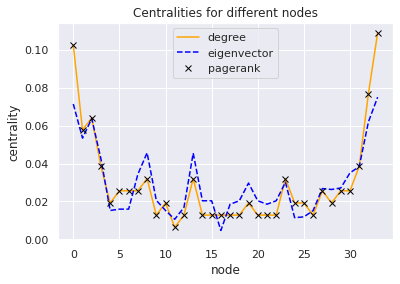

In [48]:
plt.figure
plt.title('Centralities for different nodes')
plt.plot(degr,c='orange',label='degree')
plt.plot(evec,'--',c='blue',label='eigenvector')
plt.plot(pgrk, 'x',c='black',label='pagerank')
plt.xlabel('node')
plt.ylabel('centrality')
plt.legend()
plt.show

From the graph above we can see that all three measures have fairly similar results. The first and last nodes have the highest centrality in all three cases. the nodes 10-25 all have low centralities. 

The degree and pagerank have almost identical results. The difference is of order similar to the tolerance we defined. In fact, for an undirected graph (e.g. symmetric adjacency matrix), the pagerank and degree are usually very similar as long as the pagerank formula has no damping https://arxiv.org/abs/1205.1960 https://hal.inria.fr/hal-01227383v2/document.

The eigenvector centrality is slightly different to the other two measures however. This is because the eigenvector centrality takes into account the degree of the node being measure and its neighbours. Because of this the eigenvector centrality is perhaps a bit more useful than degree and undamped pagerank centrality. For the latter, both will produce the same result for many nodes even though they have different neighbours and different behaviours. In fact, we can see that many nodes between 15 and 25 have the same value for degree and pagerank, whereas the eigenvector centrality scores these nodes differently.

### Clauset-Newman-Moore greedy modularity maximisation 

Now we will use the  Clauset-Newman-Moore greedy modularity maximisation algorithm to find the optimum number of clusters. This will be done using the networkx package. This is a fast algorithm that detects communities by maximising modularity. Structuring a graph into communities is to group vertices in such a way that there is a higher density of edges between the same communities than different communities.

Modularity is defined as 
$$Q = \frac{1}{2m} \sum_{vw} [A_{vw} - \frac{k_v k_w}{2m}] \delta(c_v,c_w) $$

where $k_v,k_w$ are the degrees of vertices v,w $A_{vw}$ is the v,w entry in the adjacency matrix,m is the number of edges in the graph, and $c_v,c_w$ are the communities v and w

In [49]:

k_graph = nx.convert_matrix.from_numpy_matrix(a_mat) #convert adjacency matrix to graph


kstar = nx.algorithms.community.modularity_max.greedy_modularity_communities(k_graph) #find communities


We will plot our communities with the code below, the three colours represent the different 3 communities and each node has been labelled.

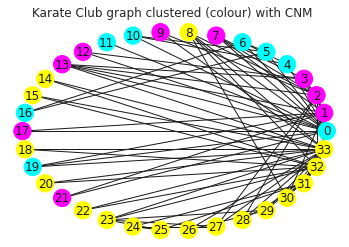

In [50]:

colour_map =[]#assign colours
for node in k_graph:
    if node in kstar[0]:
        colour_map.append('yellow')
    elif node in kstar[1]:
        colour_map.append('magenta')
    else:
        colour_map.append('cyan')
pos=nx.circular_layout(k_graph)

ax = plt.gca()
ax.set_title('Karate Club graph clustered (colour) with CNM ')
nx.draw(k_graph,pos=pos, node_color=colour_map, with_labels=True,ax=ax) #draw graph

sortdeg = np.argsort(degr) #sort
top8nodes = sortdeg[-8:] #extract top 8 nodes based off degree

sortpr = np.argsort(pgrk)
top8prn = sortpr[-8:] #top nodes based off pagerank



We will replot this graph but only label the top 8 nodes ranked by degree centrality

{0: Text(1.0, 1.2564497938803791e-09, '0'),
 1: Text(0.9829730987548828, 0.1837495130944091, '1'),
 2: Text(0.9324722290039062, 0.3612416697192031, '2'),
 3: Text(0.8502171039581299, 0.526432157819255, '3'),
 23: Text(-0.44573837518692017, -0.8951632963967484, '23'),
 31: Text(0.8502170443534851, -0.5264322745156449, '31'),
 32: Text(0.9324722290039062, -0.3612416970086259, '32'),
 33: Text(0.9829730987548828, -0.18374943607570352, '33')}

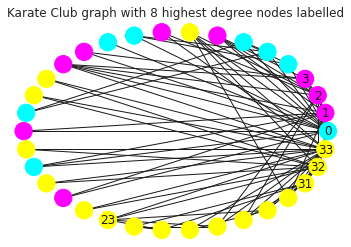

In [51]:
deglab= {}
for node in k_graph.nodes():
    if node in top8nodes:
        deglab[node] = node
        

ax = plt.gca()
ax.set_title('Karate Club graph with 8 highest degree nodes labelled')
pos=nx.circular_layout(k_graph)
nx.draw(k_graph, pos=pos, node_color=colour_map, with_labels=False) #draw graph
nx.draw_networkx_labels(k_graph,pos=pos,labels=deglab)

We will replot this graph for the top 8 nodes from pagerank.

{0: Text(1.0, 1.2564497938803791e-09, '0'),
 1: Text(0.9829730987548828, 0.1837495130944091, '1'),
 2: Text(0.9324722290039062, 0.3612416697192031, '2'),
 3: Text(0.8502171039581299, 0.526432157819255, '3'),
 13: Text(-0.7390088438987732, 0.6736957443404037, '13'),
 31: Text(0.8502170443534851, -0.5264322745156449, '31'),
 32: Text(0.9324722290039062, -0.3612416970086259, '32'),
 33: Text(0.9829730987548828, -0.18374943607570352, '33')}

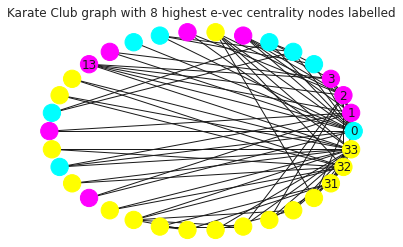

In [52]:
pgrlab= {}
for node in k_graph.nodes():
    if node in top8prn:
        pgrlab[node] = node

        
ax = plt.gca()
ax.set_title('Karate Club graph with 8 highest e-vec centrality nodes labelled')
pos=nx.circular_layout(k_graph)
nx.draw(k_graph, pos=pos, node_color=colour_map, with_labels=False) #draw graph
nx.draw_networkx_labels(k_graph,pos=pos,labels=pgrlab)

At first it appears that the two graphs are very slightly different, but upon further inspection, this discrepency is a result of python array sorting  behaviour. Nodes 23 and 13 both have degree 5 and are both jointly ranked on pagerank and degree, which we found to have effectively identical results in the last section since our graph is undirected and our pagerank is undamped.

We note that this algorithm has clustered our graph into 3 communities, which is a slightly different result to the optimum k=2 that we found in the last section.

Something else worth noting is that node 0 has the highest degree, yet is the node from its community. One might consider if it wasn't for this node, the algorithm would choose to cluster into 2 communities and not 3. However this is not true and removing this node 0 will produce a result with 5 communities again, not 2. Though this is a very crude test and removing single nodes is not a good way to compare graphs since it removed more connections than just those related to the single node.

In [53]:
k_graph2 = nx.convert_matrix.from_numpy_matrix(a_mat[1:,1:]) #convert adjacency matrix to graph
kstar2 = nx.algorithms.community.modularity_max.greedy_modularity_communities(k_graph2) #find communities
print('number of communities when node 0 is removed:',len(kstar2))

number of communities when node 0 is removed: 5


The last part of this section will be computing the adjusted rand index for the best CH score k-means cluster (k=2) and the clusters from maximising modularity in the most recent section.

The adjsuted rand index is defined as $$ARI = \frac{\sum_{ij} \binom{n_{ij}}{2} - [\sum_i \binom{a_i}{2}\sum_j \binom{b_j}{2}  ]/\binom{n}{2}}  {\frac{1}{2} [\sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}] - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}]/\binom{n}{2}} $$

Where $n_{ij}$ is the i,j entry of the contingency table, the contigency table a count of the number of nodes that are are across diffferent clusters in each clustering, and $a_i$$b_j$ are the i/j row/column sumns.

The function below implements this for an input of two clusterings. Each input should be a list, and the objects of this list are the clusters of nodes.

In [54]:
cnm = [list(c) for c in kstar] #nodes clustered into arrays
labs = km_cluster(f_mat,2)[0] #labels
#km = [np.where(labs==0).tolist(),np.where(labs==1).tolist()] #nodes clustered into arrays
km = [np.where(labs==k) for k in range(2)] #nodes clustered into arrays

def rand(cluster1, cluster2):
    cont = np.zeros((len(cluster1),len(cluster2)))

    for ci in range(len(cluster1)): #for each cnm
        for cj in range(len(cluster2)): #for each km cluster
            cont[ci,cj] = len(np.intersect1d(cluster1[ci],cluster2[cj])) #count intersect

    asum = np.sum(cont, axis=1) #contigency table sums
    bsum = np.sum(cont, axis=0)

    ij_bin = np.sum(scipy.special.binom(cont,2)) #binomial coefficients
    i_bin = np.sum(scipy.special.binom(asum,2))
    j_bin = np.sum(scipy.special.binom(bsum,2))

    nance1 = ij_bin - (i_bin*j_bin)/(scipy.special.binom(34,2))
    nance2 = 0.5 *(i_bin + j_bin) - (i_bin*j_bin)/(scipy.special.binom(34,2))

    rand = nance1/nance2
    return rand


In [56]:


#load truth
truth = pd.read_csv ('ground_truth_karate_club.csv', delimiter=",")
tru_n = (np.where(truth.iloc[:,1] == 'Mr. Hi'), np.where(truth.iloc[:,1] == 'Officer')) #get node list

Below, we will compute the ARI for the 3 clusterings: k-means clustering (k=2), Clauset-Newman-Moore greedy modularity maximization (3 clusters), and the ground truth.

The ARI is especially useful because it can be used to compare clusterings of different sizes and clusterings with different numbers of clusters.

In [57]:
print('k_means and Clauset-Newman-Moore:',rand(km,cnm))
print('k-means and truth:',rand(km,tru_n))
print('Clauset-Newman-Moore and truth:',rand(cnm,tru_n))

k_means and Clauset-Newman-Moore: -0.031487014479429976
k-means and truth: 0.0012970168612192327
Clauset-Newman-Moore and truth: 0.5684394071490846


We can see from the ARI that the k-means is very different to the ground truth and the Clauset-Newman-Moore clustering; The ARI value is very small. The Clauset-Newman-Moore (CNM) clustering was fairly similar to the truth with a coefficient of 0.57. The CNM clustering was a lot better than our best k-means clustering.

This might seem a bit surprising because the CNM method identified 3 clusters, whereas the best k-means method identified 2, and we know the truth has 2 clusters. However, we can believe that the CNM has a better result because modularity is a much better metric for identifying clusters than euclidean distance for this specific problem. Another explanation would be that the features of the dataset do not have a euclidean relationship and this is something that scaling/standardising will not fix. Perhaps we could use manhattan, jacquard or other distance measures in the future and measure the stress to see how well these distances are suited to this dataset.

For this section we conclude that despite using various metrics to find an optimum cluster size, k-means clustering (k=2) was not a suitable method for clustering the karate club. The CNM method worked significantly better, whilst still being a fast greedy method, since it used modularity to identify the clusters. Though with an ARI of 0.57, this method was still not ideal.

## Mastery material

###Louvain algorithm

As part of the mastery material we will also look into using the Louvain method to maximise modularity.

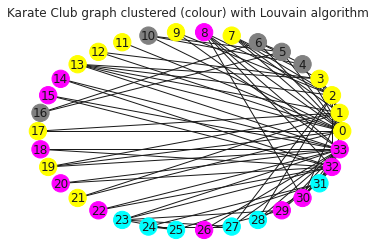

In [58]:
import community as community_louvain
louv = community_louvain.best_partition(k_graph)


colour_map =[]#assign colours
for node in k_graph:
    if louv[node] ==0:
        colour_map.append('yellow')
    elif louv[node] ==1:
        colour_map.append('magenta')
    elif louv[node] ==2:
        colour_map.append('gray')
    elif louv[node] ==3:
        colour_map.append('cyan')
#pos=nx.circular_layout(k_graph)


ax = plt.gca()
ax.set_title('Karate Club graph clustered (colour) with Louvain algorithm ')
nx.draw(k_graph,pos=pos, node_color=colour_map, with_labels=True) #draw graph


This algorithm gives different results each time we run it and so it would be unfair to just compare one output of this function to the CNM method.

Below we will run the Louvain method 100 times and compare each result to the truth.

mean: 0.44058697556410154
variance: 0.0017444002548971272
range: 0.3697036223929748 - 0.5088640840446488


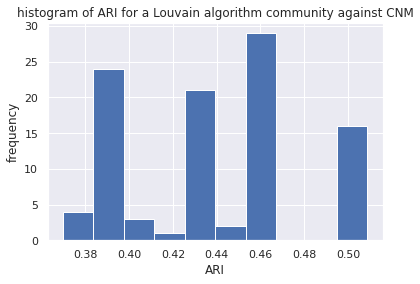

In [59]:
rands = np.zeros(100)

for i in range(100): #multiple runs
    louvdict = community_louvain.best_partition(k_graph) #run louvain algorithm
    louvlab = np.array(list(louvdict.values())) # list of labels
    communities = [np.where(louvlab==k) for k in range(len(np.unique(louvlab)))] #array of communities
    rands[i] = rand(communities, tru_n) #calculate ARI 
    
plt.hist(rands)
plt.title('histogram of ARI for a Louvain algorithm community against CNM')
plt.xlabel('ARI')
plt.ylabel('frequency')

print('mean:',np.mean(rands))
print('variance:', np.var(rands))
print('range:',np.amin(rands),'-',np.amax(rands))

From these results we can see that the louvain method performs worse than the CNM in 2.3.2. Specifically, on average it performs almost worse according to ARI (0.0.44). At best, the Louvain method still performs worse (0.51). 

Another thing to note is that this algorithm seems to always identify 4 communities as opposed to the 3 that CNM identified. We know that the ground truth has 2 clusters and while neither 3 or 4 are corect, clustering into 4 communities seems to be worse than 3.

The CNM and Louvain methods have similarities- they are both greedy hierarchical clustering methods that work by optimising modularity http://ece-research.unm.edu/ifis/papers/community-moore.pdf. They both calculate whether there is an increase in modularity when new communities are formed. However there are differences which explain this performance gap. 

The key difference is that the Louvain algorithm will mode single nodes to communities improve modularity, whereas the CNM will combine pairs of communities to improve modularity. This perhaps explains why the CNM believes 3 clusters is optimal and the Louvain chooses 4. The CNM is not limited to only moving one node at a time and will not stuck in a local minima like the Louvain method. https://web.stanford.edu/class/cs224w/project/26425107.pdf

For this karate club problem where the truth has exactly two clusters, we believe the CNM performed better because it was able to agglomorate the nodes more and into a smaller number of communities than the Louvain method could.


### Spectral partitioning

We are interested in finding communities in the karate club network using modularity maximistion with spectral partitioning. 

The main steps are:
1. Find the spectral partition of the network (using the normalised Laplacian).
2. Calculate the modularity of the spectral partition.
3. Then we want to partition further by looking at each subgraph (defined as a community). We take the first sub-graph and compute its spectral partition. Combining this split with the original partition, does the modularity increase or decrease? If it increases then keep this partition. Do this for each subgraph.
4. Stop when further partitions don't improve the modularity.

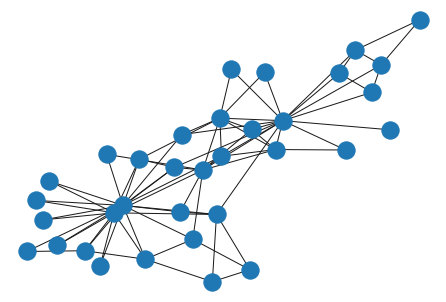

In [60]:
# call the karate club graph
g = nx.karate_club_graph()

# plot the graph
pos = nx.spring_layout(g)
nx.draw(g, pos=pos)

# return the adjacency matrix as a NumPy array
A = nx.to_numpy_array(g)

In [61]:
def get_subgraph(A, nodes):
    """ get the subgraph based on a list of nodes """
    nodes.sort() #sort list so nodes are ordered
    A_subgraph = A[:,nodes][nodes,:]## <-- EDIT THIS LINE
    return A_subgraph # return a 2D NumPy array


def get_laplacian(A):
    """ Get Laplacian of my network """
    weighted_degree = A.sum(axis=1) 
    weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
    D_inv_sqrt = np.diag(weighted_degree_sqrt)
    L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))
    return L_norm # return a 2D NumPy array

def get_spectral_partition(A):
    """ Compute spectral partition with Laplacian """
    L_norm = get_laplacian(A)
    
    eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)
    second_eigenvector = eigenvecs[:,1] #
    spectral_partition = second_eigenvector
    spectral_partition[spectral_partition<0] = 0 #
    spectral_partition[spectral_partition>0] = 1
    
    return spectral_partition # return a 1D NumPy array

def get_modularity(A, partition):
    """ Compute the Modularity of partition with network """
    degree_weighted = A.sum(axis=1)   ## <-- EDIT THESE LINES
    m = degree_weighted.sum() / 2
    spectral_partition = get_spectral_partition(A)
    Q = 0
    for i in range(A.shape[0]):
      for j in range(A.shape[0]):
        
        # only look at nodes within the same community
        if spectral_partition[i]==spectral_partition[j]:
          # add the difference between edge and expected edge weight based on degree
          Q += A[i,j] - ((degree_weighted[i]*degree_weighted[j])/(2*m)) ## <-- SOLUTION

    # finally normalise by the total edge weight
    Q = (1/(2*m))*Q #
    
    return Q # return a float

def set_new_partition(possible_partition, sub_partition, idx_nodes, comm_id):   
    """ Combine original partition with new subgraph partition """
    sub_partition[sub_partition==0] = comm_id
    sub_partition[sub_partition==1] = comm_id+1   
    possible_partition[idx_nodes] = sub_partition
    return possible_partition # return a NumPy array

In [62]:
increasing_q = True

# initial spectral partition
partition = get_spectral_partition(A)
Q = get_modularity(A, partition)
print('Initial Q:', Q)
comm_id = 0

# loop over until modularity doesn't increase further
while increasing_q:
    
    # define the original modularity
    Q_orig = Q
    
    # finding unique communities in partition
    unique_comms = np.unique(partition)   
    
    # loop over each community in the partition
    for comm in unique_comms:
        
        
        # make a copy of best partition so far  
        possible_partition = partition.copy()
        
        # find index of all nodes in community
        idx_nodes = np.where(partition==comm)[0]
        
        # get subgraph of graph
        A_sub = get_subgraph(A,idx_nodes)  ## <-- EDIT THIS LINE
        
        # compute spectral partition of subgraph
        sub_partition = get_spectral_partition(A_sub)  ## <-- EDIT THIS LINE
        
        # iterating comm id
        comm_id += 2
        
        # define new partition
        possible_partition = set_new_partition(possible_partition, sub_partition, idx_nodes, comm_id)
        
        # compute modularity of new possible partition
        Q_new = get_modularity(A,possible_partition)  ## <-- EDIT THIS LINE
        # if the partition of subgraph improved modularity then keep it
        if Q_new>Q:
            partition = possible_partition.copy()
            print('New Q: {}, Partition: {}'.format(Q_new, partition))
            Q = Q_new
            
    # break out of the while loop if modularity isn't increasing
    if not Q>Q_orig: 
        increasing_q = False
        
print('------------------')        
print('Optimal number of clusters: {}'.format(np.unique(partition).shape[0]))

Initial Q: 0.35996055226824286
------------------
Optimal number of clusters: 2


The algorithm converges after one iteration and identifies k=2 as the optimal mumber of clusters. This looks promising as we know the ground truth has two clusters. We will check the ARI next.

In [63]:
speccom = [np.where(partition==k) for k in range(len(np.unique(louvlab)))][:2] #spectral clusters


print('ARI:',rand(speccom,tru_n))

ARI: 0.7717250324254216


This final method has given us our highest ARI score with respect to the truth; so this clustering is most similar to the truth. This method is repeatable too (returns the same clustering), unlike the Louvain method which returned drastically different results each time it was run. It is interesting to note that our algorithm converged after one iteration, which suggests the initial spectral partitioning, with no further calculations has given us this good result.

Spectral partitioning works well for community detection because it only uses connectivity to measure closeness, and not some distance metric (like k-means which fails here since our data is not linearly separable). 

Now our method calculates a laplacian matrix and the eigenvalues are related to the connectedness of the graph. In fact, the a completely disconnected graph has all its eigenvalues as 0. Adding edges to this disconnected graph, we will find that eigenvalues increase. We can look at the number of 0 value eigenvalues to find the number of connected components of the graph. This is a better method in this problem than comparing CH score. The first non zero eigenvalue is also very useful, this determines the spectral gap- the density of the graph's connections. The second non zero eigenvalue (Fiedler value) helps us find the minimum cut to separate the graph into two connected components if the original graph was completely connected. With this information, we can iterate different partitionings and try and maximise modularity to help us split our graph into the optimal number of clusters.

#Conclusion

To conclude this project:
In task 1, we found that convolutional neural networks perform a lot better than multilayer perceptrons for image classification because the CNN recognises that pixels should be grouped with pixels in its neighbourhood. The MLP tries to make features from distant pixels, which is not useful in an image where details exist in local neighbourhoods.

In task 2, we clustered a graph with different methods. A relationship between PCA and K-means clustering was discovered. We used metrics like the CH score to find the best k values for k-means clustering. However, when we compared this result to the ground truth, we discover that this clustering is no good. Instead, we found out that the CNM modularity maximisation algorithm performed much better, though still not great (ARI<0.6). This is because this method uses modularity and not distances to find the communities. The distances between the variables in the feature matrix turned out to be not very useful and we believe that this information was either not euclidean in nature, or was simply not correlated to the clustering. 

In task 3, we used tried the Louvain algorithm which is very similar to the CNM. Though this Louvain method did not perform as well as the CNM. This was likely due to the CNM being able to combine whole communities and not just move single nodes like the Louvain algorithm would. Both methods are still greedy methods that have their limitations and converge before finding better clusterings. So finally, we tried spectral partitioning with modularity maximisation. This had the best result by far.